# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [47]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [48]:
 device ='cuda' if torch.cuda.is_available() else 'cpu'

-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [49]:
learning_rate = 0.001
train_batch_size = 100 
test_batch_size = 100
num_epoch = 50
dir_output = '/home/mmvc/dl1/output'

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [50]:
if os.path.exists(dir_output) == False:
    os.makedirs(dit_output)
    print('New directory made for output: ', dir_output)
else:
    print('Directory for output already exists: ', dir_output)

Directory for output already exists:  /home/mmvc/dl1/output


-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [51]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [52]:
train_set = dset.CIFAR10(root='/home/mmvc/dl1/data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = dset.CIFAR10(root='/home/mmvc/dl1/data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paper below to understand the structure.
### https://arxiv.org/abs/1409.4842



------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of tow 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [53]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )
        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )
        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )
        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
       
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

-----
### GoogLeNet Module (There exist many implement methods)


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convaluation with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    3. Two Inception block
    
    4. Maxpooling layer
    
    5. Seven Inception block
    
    6. Average Pooling layer
    
    7. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [54]:
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.a1 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.a2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.a3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.a4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.a5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.a6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.a7 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.a9 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.avg_pool = nn.AvgPool2d(8, stride=1)
        
        self.fcl = nn.Linear(1024, 10)
        
    def forward(self, x):
            res = self.pre(x)
            res = self.a1(res)
            res = self.a2(res)
            res = self.max_pool(res)
            res = self.a3(res)
            res = self.a4(res)
            res = self.a5(res)
            res = self.a6(res)
            res = self.a7(res)
            res = self.max_pool(res)
            res = self.a8(res)
            res = self.a9(res)
            res = self.avg_pool(res)
            res = res.view(res.size(0), -1)
            res = self.fcl(res)
            return res
    

### Next, we create the networka and send it to the target device

In [55]:
gNet = GoogleNet().to(device)
print(gNet)

GoogleNet(
  (pre): Sequential(
    (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (a1): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (b3): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gNet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [57]:
print(len(train_loader))

500


# Training and Testing
### Implementing and evaluating the classification pipeline in order to print out loss and accuracy

In [58]:
losses = []
tl = []
acc = []

############# Train ###############
for epoch in range(num_epoch):
    epoch_loss = 0
    idx = 1
    scheduler.step()
    print(f'Epoch #{epoch+1}  Learning_rate: {scheduler.get_lr()}')
    for trainData, trainLabel in train_loader:
        trainData = trainData.to(device)
        trainLabel = trainLabel.to(device)
        optimizer.zero_grad()
        predictedLabel = gNet(trainData)
        loss = criterion(predictedLabel, trainLabel)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item () * trainData.size(0)
        if idx % 100 == 0:
            print (f'Step [{idx}/{len(train_loader)}] | Loss: {loss.item():.4f}')            
        losses.append(loss.item())
        idx += 1
    epoch_loss = epoch_loss/len(train_loader.dataset)
    tl.append(epoch_loss)
    print(f'Training Loss: {train_loss:.6f}')
        
    ############# Accuracy ###############
    with torch.no_grad():
        correct = 0
        total = 0
        for testData, testLabels in test_loader:            
            testData = testData.to(device)
            testLabels = testLabels.to(device)
            result = gNet(testData)
            val, pred = torch.max(result.data,1)
            
            total += testLabels.size(0)
            correct += (pred == testLabels).sum().item()
        accuracy = (correct/total) * 100
        acc.append(accuracy)
        print(f'Acurracy: {accuracy}% \n')

Epoch #1  Learning_rate: [0.001]


/home/mmvc/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/mmvc/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step [100/500] | Loss: 1.6035
Step [200/500] | Loss: 1.3082
Step [300/500] | Loss: 1.1714
Step [400/500] | Loss: 0.9291
Step [500/500] | Loss: 0.8731
Training Loss: 0.300843
Acurracy: 67.25% 

Epoch #2  Learning_rate: [0.001]
Step [100/500] | Loss: 0.7631
Step [200/500] | Loss: 0.6288
Step [300/500] | Loss: 0.7194
Step [400/500] | Loss: 0.8416
Step [500/500] | Loss: 0.6758
Training Loss: 0.300843
Acurracy: 77.60000000000001% 

Epoch #3  Learning_rate: [0.001]
Step [100/500] | Loss: 0.6405
Step [200/500] | Loss: 0.4820
Step [300/500] | Loss: 0.6104
Step [400/500] | Loss: 0.6043
Step [500/500] | Loss: 0.5662
Training Loss: 0.300843
Acurracy: 80.78% 

Epoch #4  Learning_rate: [0.001]
Step [100/500] | Loss: 0.5432
Step [200/500] | Loss: 0.5358
Step [300/500] | Loss: 0.6209
Step [400/500] | Loss: 0.3492
Step [500/500] | Loss: 0.3871
Training Loss: 0.300843
Acurracy: 82.82000000000001% 

Epoch #5  Learning_rate: [1e-05]
Step [100/500] | Loss: 0.2562
Step [200/500] | Loss: 0.2202
Step [300/50

In [61]:
l = np.array(losses)
print(l.shape)
print(l)

(25000,)
[2.32378626 2.39736128 2.29631972 ... 0.14248675 0.10771556 0.12590118]


# Plotting loss convergence & model accuracy

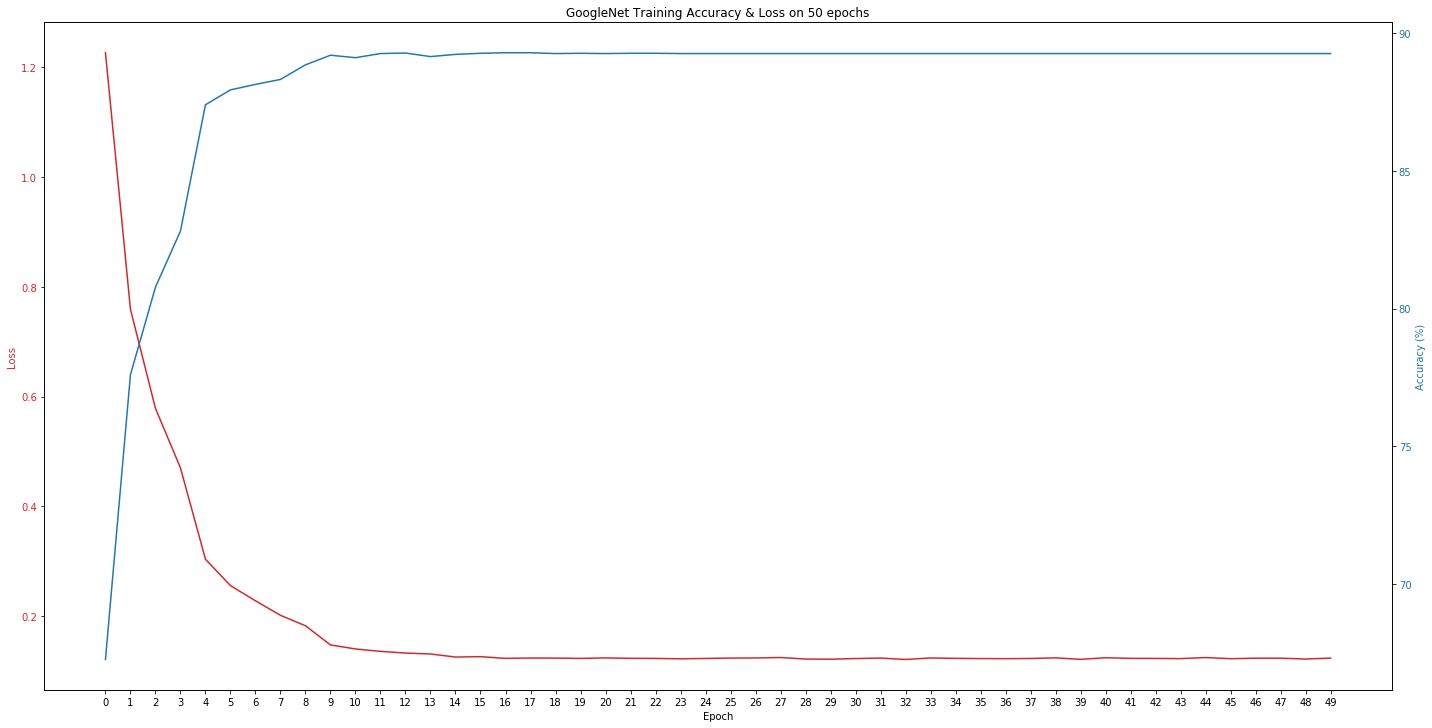

In [84]:
l = np.array(tl)

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(l, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color) 
ax2.plot(acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'GoogleNet Training Accuracy & Loss on {num_epoch} epochs')
plt.xticks(np.arange(0,num_epoch,1), rotation='vertical')
plt.show()

# Citation

1. https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
2. https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/
3. https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/